### Pruebas OLA 'Overlapp and Add'

En este notebook se detallan las pruebas subjetivas y objetivas realizadas al algoritmo, previamente a implementarlo en conjunto con el HPS y PV.

In [134]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
import soundfile 
from utils.wav_utils import read_wav, save_wav 

import ola 
from pytsmod import olatsm
#from test import plotting 

from test import test_objective as TO, test_subjective as TS, plotting, signals 


Observacion:
tamaño de ventana en segundos: w_size = N/fs

Para fs = 44100

algunos casos:
Si N = 441 -> w_size = 10 ms

Si N = 882 -> w_size = 20 ms

Si N = 1024 -> w_size = 23 ms

Si N = 2048 -> w_size = 46 ms

Si N = 4096 -> w_size = 92 ms

Si N = 8192 -> w_size = 184 ms

#### ALGUNAS PRUEBAS INICIALES SUBJETIVAS. 

Comparando audios reales (.wav) modificados con la libreria de referencia
pytsmod y con la nuestra.

#### CASO 1:

Audio: 'piano_cerca.wav' mono, 48k, 5 seg (armonico)

Probamos variando el alpha, el N de la ventana y manteniendo un Hs=N//2

In [2]:
#lectura de audio
fs = 48000
piano_cerca, _ = read_wav('audios/piano_cerca.wav', fs)

#pytsmod version
pianocerca_refe= olatsm.ola(piano_cerca, .7, win_type='hann', win_size=512, syn_hop_size=512//2)

#nuestra version
pianocerca_ours = ola.TSM_OLA(piano_cerca, 512, .7, 512//2)

In [3]:
#Escucho señal modificada by pystmod
Audio(pianocerca_refe, rate=48000)


In [4]:
#Escucho señal modificada por nuestro code
Audio(pianocerca_ours, rate=48000)

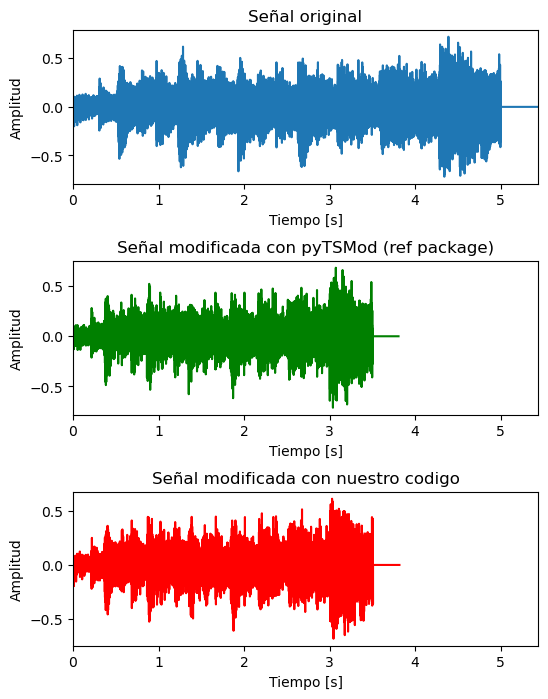

In [5]:
#Grafiquemos

plotting.basic_3plot(piano_cerca,pianocerca_refe,pianocerca_ours,48000)


##### OBSERVACIONES:

En terminos generales, funciona de manera similar en comparacion con la libreria propuesta de referencia.

Se puede notar la distorsion causada por el proceso de TSM OLA en esta señal armonica, como fue detallado en la bibliografia.

Para N = 1024 o 512 da optimos resultados, lo que se condice con los papers. Si disminuimos mucho el tamaño de la ventana modifica bastante el pitch, y si lo aumentamos da muchas modulaciones en amplitud.

#### CASO 2:

Audio: 'drumperc.wav' mono, 44.1k, 8 seg (percusivo).

Probamos variando el alpha, el N de la ventana y manteniendo un Hs=N//2

In [23]:
#lectura de audio
fs = 44100
drums, _ = read_wav('audios/drumperc.wav', fs, mono=True)

#pytsmod version
drums_tsmrefe= olatsm.ola(drums, .7, win_type='hann', win_size=512, syn_hop_size=512//2)

#nuestra version
drums_tsm_untref = ola.TSM_OLA(drums, 512, .7, 512//2)

 

In [21]:
#Escucho señal modificada by pystmod
Audio(drums_tsmrefe, rate=44100) 

In [20]:
#Escucho señal modificada por nuestro codigo
Audio(drums_tsm_untref, rate=44100)

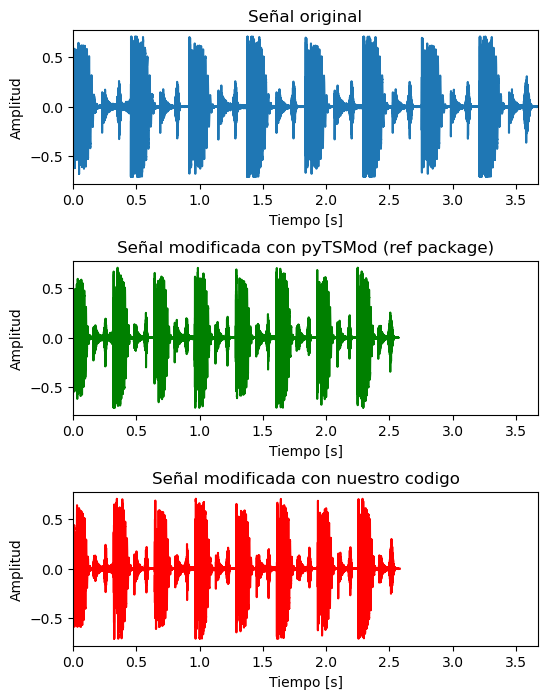

In [19]:
#Grafiquemos

plotting.basic_3plot(drums,drums_tsmrefe,drums_tsm_untref,48000)

##### OBSERVACIONES:

Como en el caso 1, funciona de manera similar en comparacion con la libreria propuesta de referencia.

Se puede notar una mejor percepcion sonora en cuanto al TSM aplicado, para valores de alfa no muy extremos, comprendidos entre 0.6 y 1.5 aproximadamente. A medida que la modificacion de escala se vuelve mas extrema, se comienza a notar mas pero igual perceptualmente no pareceria grave, dada la simplicidad del algoritmo. Hay que evaluar hasta que limites de alpha tiene sentido en la aplicacion.

Para N = 1024 o 512 da buenos resultados, lo que se condice con los papers. 
Si aumentamos mucho el tamaño de la ventana comienza a hacerse notorio el artefacto de 'transient doubling' descripto en la bibliografia.
Si reducimos el tamaño de la ventana por debajo de 512, lo que seria menor a 10ms para fs de 44100 o 48000, en la version de referencia funciona y pareceria reducir el cambio de pitch. En nuestro codigo, no compila y tira error de dimensiones al efectuar el tsm. (habria que revisar)

Pero en terminos generales, se puede efectuar para valores de ventanas de N=512 y N=1024.

A continuacion, podemos proceder a realizar PRUEBAS OBJETIVAS sobre el rendimiento del algoritmo, en comparacion con señales simples ideales, y sus modificaciones de duracion ideales, sin ninguna variacion de pitch.

#### PRUEBAS INICIALES OBJETIVAS

En esta sección se busca analizar como varia el algorítmo antes distintos casos de interes y bajo distintos parámetros.
Como el procedimiento de TSM con OLA es relativamente simple, el parametro mas critico a la hora de ejecutarlo es el tamaño de la ventana N. 
En los diccionarios se deja constancia de los distintos tipos de configuración probadas bajo estos test.

In [88]:
#Diccionarios utiles para las pruebas objetivas (alpha menor a 1)
alpha = .7 
cfg1 = {"N": 8192, "Hs": 8192//2, "alpha": alpha,}
cfg2 = {"N": 8192, "Hs": 8192//2, "alpha": alpha,}
cfg3 = {"N": 4096, "Hs": 4096//2, "alpha": alpha,}
cfg4 = {"N": 4096, "Hs": 4096//2, "alpha": alpha,}
cfg5 = {"N": 4096, "Hs": 4096//2, "alpha": alpha,}
cfg6 = {"N": 2048, "Hs": 2048//2, "alpha": alpha,}
cfg7 = {"N": 2048, "Hs": 2048//2, "alpha": alpha,}
cfg8 = {"N": 1024, "Hs": 1024//2, "alpha": alpha,}
cfg9 = {"N": 512, "Hs": 512//2, "alpha": alpha,}

El primer test compara señales ideales respeto a un caso base de interes particular para cada algorítmo. En el primer test se usará una señal SENOIDAL. Primero se muestra un ejemplo con una frequencia arbitraria y luego se realiza el mismo analisis para cada frequencia.

Tener en cuenta que este no es el tipo de señal adecuada para el OLA pero es bueno hacer el analisis para verificar y tener en cuenta.

#### Prueba1: alphas menores a 1 con señal senoidal

Variamos la frecuencia del seno, y el N de la ventana

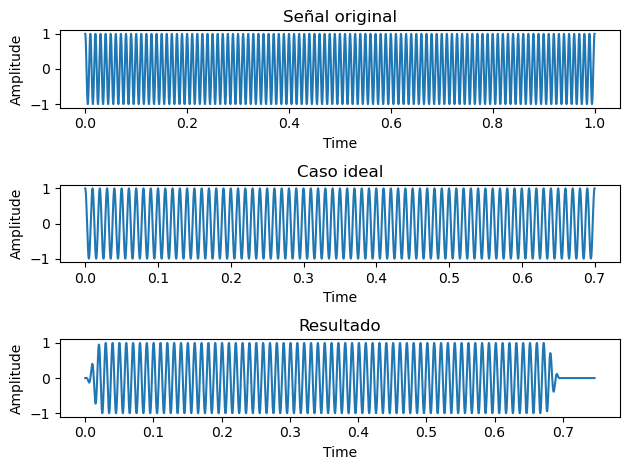

In [61]:
fs = 44100
f_analysis = 100
config = cfg7   
algorithm = "OLA"
x_base, x_ideal, x_result = TO.test_ideal_signal(algo=algorithm, f0=f_analysis, fs=fs, config=config, 
                                                 plot=True, audio_save=False, return_audios=True)

#### Observaciones: 

(Alpha 0.2 f=100) 

Se notan oscilaciones en amplitud con cfg9
Cf9 da los mejores resultados en cuanto a disminución de mod en amp, pero se nota el efecto de fade in y fade out en entrada y salida. (la ventana).
Si aumentamos mas el N de muestras (hacia cf1) se nota el mismo comportamiento de planitud en amp pero fade in y fade out mas exacerbado. Pero a partir de cf3 se rompe y distorsiona mucho. Son ventanas muy grandes y no aconsejables. Cf9 y cf8 mas recomendado.

En este seteo bajo cf9, si aumentamos la freq (100,500,1k,2k,4k,8k) se notan modulaciones en amplitud mas agresivas. Esto disminuye si aumentamos el tamaño de ventana. (config hacia cf1).

(Alphas: 0.5 0.6 0.8)

Arrancando en f=100  N=512, barriendo frecuencias de bajas hacia altas.

Se nota un comportamiento similar al anterior, pero al ser menos agresivo con la modificación de escala temporal, los artefactos indeseados mencionados anteriormente son menores. Por lo tanto, a medida que achicamos más la señal, distorsionamos más y viceversa al hacer TSM pequeños (0.9). 

//

Ademas. Tambien se ve la influencia de sumar un +N en el largo de vector de salida y en el algoritmo de OLA. Esto fue agregado porque se consideraron largos de ventana cortos, y corregia errores de dimensiones al efectuar la reubicacion temporal de la señal en la salida. Para ventanas cortas ese +N no es considerable, pero para ventanas largas si. (Que como se dijo previamente, no serian utilizadas en la practica).

#### Prueba2: alphas mayores a 1 con señal senoidal

Variamos la frecuencia del seno, y el N de la ventana

In [87]:
#Diccionarios utiles para las pruebas objetivas (alpha mayor a 1)
xalpha = 1.2 
xcfg1 = {"N": 8192, "Hs": 8192//2, "alpha": xalpha,}
xcfg2 = {"N": 8192, "Hs": 8192//2, "alpha": xalpha,}
xcfg3 = {"N": 4096, "Hs": 4096//2, "alpha": xalpha,}
xcfg4 = {"N": 4096, "Hs": 4096//2, "alpha": xalpha,}
xcfg5 = {"N": 4096, "Hs": 4096//2, "alpha": xalpha,}
xcfg6 = {"N": 2048, "Hs": 2048//2, "alpha": xalpha,}
xcfg7 = {"N": 2048, "Hs": 2048//2, "alpha": xalpha,}
xcfg8 = {"N": 1024, "Hs": 1024//2, "alpha": xalpha,}
xcfg9 = {"N": 512, "Hs": 512//2, "alpha": xalpha,}

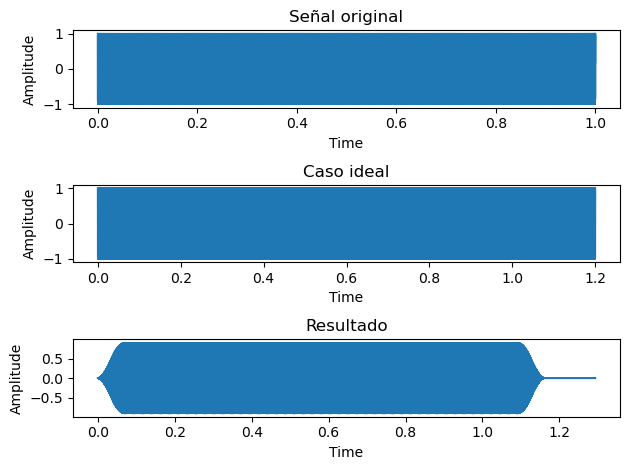

In [49]:
fs = 44100
f_analysis = 9000
config = xcfg4   
algorithm = "OLA"
x_base, x_ideal, x_result = TO.test_ideal_signal(algo=algorithm, f0=f_analysis, fs=fs, config=config, 
                                                 plot=True, audio_save=False, return_audios=True)

#### Observaciones: 

(Alpha 2 f=100)

Variamos el largo de ventana N , a la vez que la frecuencia del seno.

Siendo que Alpha 2 es un caso bastante significativo de tsm, pero suele ser usado, aunque un poco extremo, bajo f=100 y cf9 se notan pequeñas modulaciones en amp. Si aumentamos freq manteniendo el largo de ventana, parece estabilizarse y no se ven fluctuaciones muy abruptas. El fade in y fade out tampoco se ve considerable.

Bajo f=500, si aumentamos el N de ventana: hacia xcf7 no se notan modulaciones en amp pero se ve un pico en el inicio y fin que podría ser percibido como golpes, indeseado. Si continuamos aumentando el N de la ventana se hace mas extremo.,Si aumentamos mas la freq  la señal se ve atenuada en el medio de los picos en inicio y fin y estos son mas extremos. 
Por lo tanto, bajo frecuencias mas altas y Alpha 2, se sigue aconsejando ventanas mas cortas

Si aumentamos Alpha y nos vamos a casos mas extremos: 3 4 5 6

Con Alpha 3 Barriendo freqs, con N=512 pareceria no haber modulaciones en amp.
Se ve un comportamiento similar al mencionado anteriormente sin cambios significativos.
Yendo a un caso extremo Alpha 8, 
Para altas frecuencias y N=512 bajo, parece no tener muchas modulaciones.
Para bajas freq (80) y N chico ahí si se ven un poco mas. De todas fomas, es un caso extremo y en la practica no se suele usar tanto TSM.

Yendo a un caso practico, 1.2 1.4 1.5

Como se menciono en el caso de Alpha 2, similar comportamiento. Al hacer estos tsm mas sutiles, no es considerativa la modulacion en amplitud. Se verifica que con ventanas chicas suele tener los mejores resultados en la mayoría de los casos, variando la frecuencia de la señal bajo testeo.



#### Observaciones: 

Si bien esta bueno analizar con una señal seno, despues de muchos analisis parece confuso el comportamiento, pero en principio pareceria que para este tipo de señal funciona mejor con ventanas mas grandes, despreciando el efecto de fade in y fade out. Eso generaria una contradiccion con lo visto subjetivamente.

Aqui el proximo paso es seguir las pruebas con otras señales de tipo tren de impulsos o cambios rapidos de frecuencia. (Donde se verifica la eficacia del algoritmo frente a señal de tipo mas percusivo).


#### Prueba con tren de impulsos

Aca procedo a sintetizar señales simples compuestas por trenes de impulsos, y comparar como actua el TSM de OLA frente a la sintetizacion ideal de cambio de escala.

El parametro mas importante a observar es el tamaño de ventana N.



In [152]:
#funcion auxiliar para generar los impulsos
def impulses(N, fs, A, t, time = 1):

    """Generates a series impulses.
    Args:
        N (int): number of impulses.
        fs (int): Sample rate.
        A(float): Amplituf
        t(int): lenght of the impulse in miliseconds.
        time (float): Time of the signal in seconds. Default=1.
    Return:
        (np.array): Vector of impulses.
        fs(int): sample rate.
    """
    t = t/1000
    T = 1/fs
    nt = int(t/T)

    t_base = np.linspace(0, time, int(fs*time))
    x = np.zeros(len(t_base))

    t_s =  time/(N+1)  
    if t_s<=t:
        return print('The duration of the impuse exceeds the time interval between impulses')
    t_i = np.arange(t_s,time,t_s)
    n = t_i/T
    n_i = np.arange(0,nt,1)
    imp_exp = A**(n_i/(len(n_i)-1))
    

    for i in range(len(n)):
        for l in range(nt):
            x[ int(n[i])+ l] = imp_exp[l]
    return x

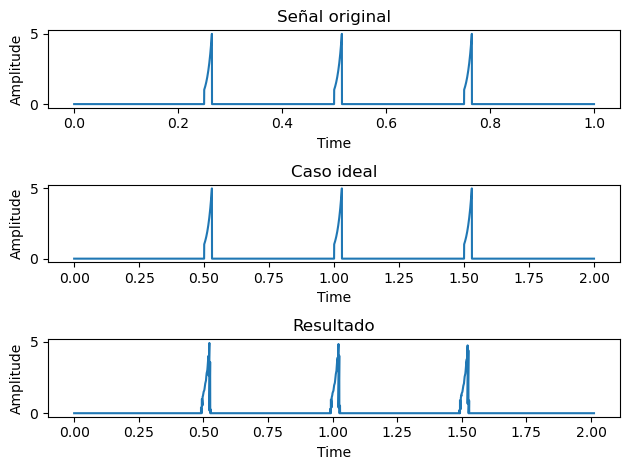

In [171]:
#CASO CON N = 512
fs = 44100
alpha = 2

x = impulses(3,fs,5, 15, time = 1) # señal original
x_idealtsm = impulses(3,fs,5, 15*alpha, time=1*alpha) # Tres impulsos de 30ms
x_result = ola.TSM_OLA(x, 512, alpha, 512//2)

titles = ["Señal original", "Caso ideal", "Resultado"]

plotting.compare_results(fs, titles, x, x_idealtsm, x_result)


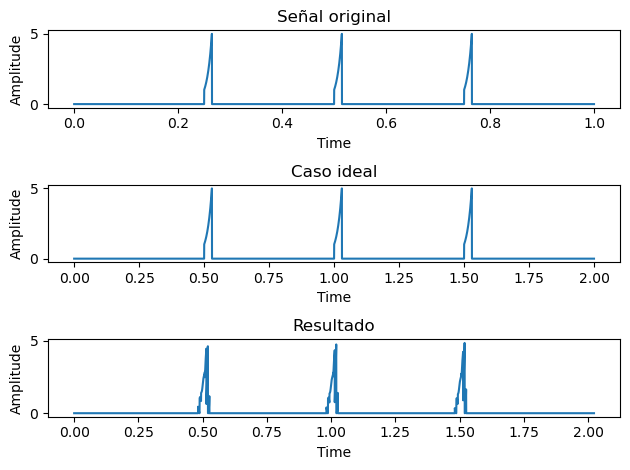

In [169]:
#CASO CON N = 1024
fs = 44100
alpha = 2

x = impulses(3,fs,5, 15, time = 1) # señal original
x_idealtsm = impulses(3,fs,5, 15*alpha, time=1*alpha) # Tres impulsos de 30ms
x_result = ola.TSM_OLA(x, 1024, alpha, 1024//2)

titles = ["Señal original", "Caso ideal", "Resultado"]

plotting.compare_results(fs, titles, x, x_idealtsm, x_result)

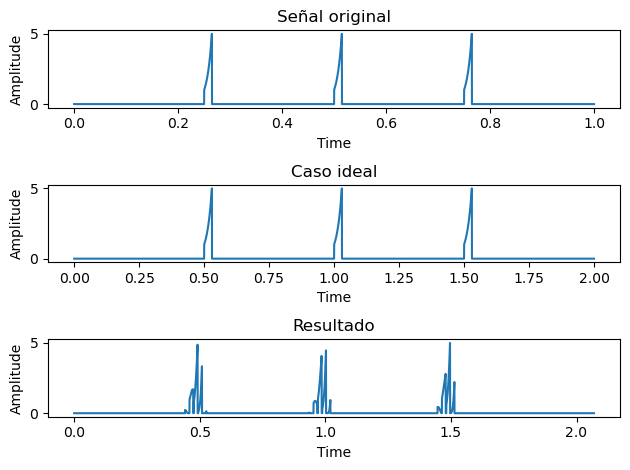

In [170]:
#CASO CON N = 1024*3
fs = 44100
alpha = 2

x = impulses(3,fs,5, 15, time = 1) # señal original
x_idealtsm = impulses(3,fs,5, 15*alpha, time=1*alpha) # Tres impulsos de 30ms
x_result = ola.TSM_OLA(x, 1024*3, alpha, 1024*3//2)

titles = ["Señal original", "Caso ideal", "Resultado"]

plotting.compare_results(fs, titles, x, x_idealtsm, x_result)

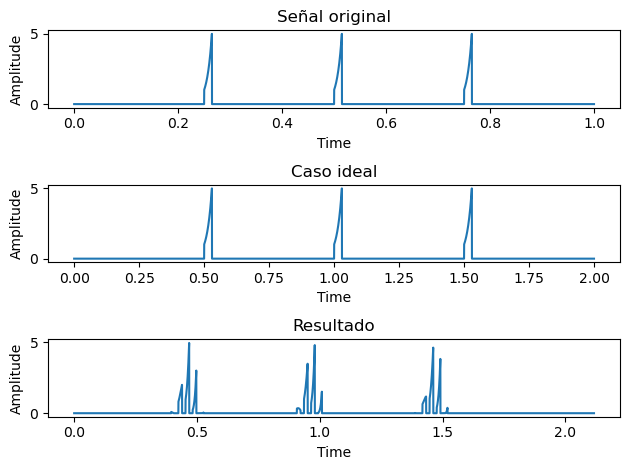

In [172]:
#CASO CON N = 1024*5
fs = 44100
alpha = 2

x = impulses(3,fs,5, 15, time = 1) # señal original
x_idealtsm = impulses(3,fs,5, 15*alpha, time=1*alpha) # Tres impulsos de 30ms
x_result = ola.TSM_OLA(x, 1024*5, alpha, 1024*5//2)

titles = ["Señal original", "Caso ideal", "Resultado"]

plotting.compare_results(fs, titles, x, x_idealtsm, x_result)

#### Observaciones:

Se puede ver como, bajo este tipo de señal, el algoritmo se comporta bien frente al caso ideal con ventanas pequeñas, N = 512 o N = 1024.

A medida que aumentamos el tamaño de la ventana, se empieza a distorsionar mas en la salida y observamos el fenomeno de transient doubling.

#### Conclusiones?

En base a lo planteado subjetivamente, se puede ver que el algoritmo implementado se comporta acorde a lo esperado, resulta en percepciones auditivas similares a las de la libreria de referencia, y da sus mejores resultados en señales de tipo percusivas con ventanas de 512 o 1024 muestas (10 - 20 ms) para evitar el efecto indeseado de 'transient doubling'. 
Se corrobora objetivamente con las comparaciones con los casos ideales hechas anteriormente.

Esto da una buena partida para comenzar las pruebas con el objetivo final de este trabajo: implementar HPS sobre la señal, y utilizar OLA en la parte percusiva y PV en la parte armonica. Siempre, teniendo en cuenta de utilizar el N recomendado de 512 o 1024.